In [41]:
import pandas as pd
import numpy as np
df=pd.read_csv(r'/home/saswata/data_science/UM_projects/world_population/world_population.csv')
df

,Rank,CCA3,Country/Territory,Capital,Continent,2022 Population,2020 Population,2015 Population,2010 Population,2000 Population,1990 Population,1980 Population,1970 Population,Area (km²),Density (per km²),Growth Rate,World Population Percentage
0,36,AFG,Afghanistan,Kabul,Asia,41128771,38972230,33753499,28189672,19542982,10694796,12486631,10752971,652230,63.0587,1.0257,0.52
1,138,ALB,Albania,Tirana,Europe,2842321,2866849,2882481,2913399,3182021,3295066,2941651,2324731,28748,98.8702,0.9957,0.04
2,34,DZA,Algeria,Algiers,Africa,44903225,43451666,39543154,35856344,30774621,25518074,18739378,13795915,2381741,18.8531,1.0164,0.56
3,213,ASM,American Samoa,Pago Pago,Oceania,44273,46189,51368,54849,58230,47818,32886,27075,199,222.4774,0.9831,0.00
4,203,AND,Andorra,Andorra la Vella,Europe,79824,77700,71746,71519,66097,53569,35611,19860,468,170.5641,1.0100,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,226,WLF,Wallis and Futuna,Mata-Utu,Oceania,11572,11655,12182,13142,14723,13454,11315,9377,142,81.4930,0.9953,0.00
230,172,ESH,Western Sahara,El Aaiún,Africa,575986,556048,491824,413296,270375,178529,116775,76371,266000,2.1654,1.0184,0.01
231,46,YEM,Yemen,Sanaa,Asia,33696614,32284046,28516545,24743946,18628700,13375121,9204938,6843607,527968,63.8232,1.0217,0.42
232,63,ZMB,Zambia,Lusaka,Africa,20017675,18927715,16248230,13792086,9891136,7686401,5720438,4281671,752612,26.5976,1.0280,0.25


In [42]:
import pandas as pd
import statsmodels.api as sm

# --- Melt the Data ---
pop_cols = [col for col in df.columns if 'Population' in col and 'World' not in col]
df_melted = df.melt(
    id_vars=['Country/Territory', 'Area (km²)', 'Growth Rate'],
    value_vars=pop_cols,
    var_name='Year',
    value_name='Population'
)
df_melted['Year'] = df_melted['Year'].str.extract(r'(\d{4})').astype(int)
df_melted['Date'] = pd.to_datetime(df_melted['Year'].astype(str) + '-01-01')  # Set date as 1st Jan of each year
df_melted.sort_values(by=['Country/Territory', 'Date'], inplace=True)

# --- Feature Engineering ---
df_melted['Density'] = df_melted['Population'] / df_melted['Area (km²)']

# Initialize Growth and Growth Rate Δ with NaN
df_melted['Growth'] = pd.NA

# Set Growth and Growth Rate Δ for the first year (1970) as 0
df_melted.loc[df_melted['Year'] == 1970, 'Growth'] = 0

# Calculate Growth and Growth Rate Δ, starting from 1971 (second year)
for country in df_melted['Country/Territory'].unique():
    country_df = df_melted[df_melted['Country/Territory'] == country].sort_values(by='Year').copy()
    
    # Calculate Growth (change in population relative to previous year) and Growth Rate Δ (difference of Growth)
    for i in range(1, len(country_df)):
        current_year = country_df.iloc[i]
        previous_year = country_df.iloc[i-1]
        
        # Calculate Growth Rate (change in population from previous year to current year)
        growth_rate = (current_year['Population'] - previous_year['Population']) / previous_year['Population']
        df_melted.loc[(df_melted['Country/Territory'] == country) & (df_melted['Year'] == current_year['Year']), 'Growth'] = growth_rate
        


# --- Extrapolation for 1970 ---
# After calculating growth for subsequent years, we can extrapolate growth for the first year.
# We'll simply carry forward the second year’s growth and growth rate change to the first year.

for country in df_melted['Country/Territory'].unique():
    country_df = df_melted[df_melted['Country/Territory'] == country].copy()
    
    # Extrapolate growth and rate of change of growth rate from second year to the first year
    if 1971 in country_df['Year'].values:
        growth_2nd_year = country_df[country_df['Year'] == 1971]['Growth'].values[0]
        
        # Extrapolate using 2nd year's values for the first year
        df_melted.loc[(df_melted['Country/Territory'] == country) & (df_melted['Year'] == 1970), 'Growth'] = growth_2nd_year

df_melted = df_melted.drop(['Growth Rate'], axis=1)
df_melted.head(20)

,Country/Territory,Area (km²),Year,Population,Date,Density,Growth
1638,Afghanistan,652230,1970,10752971,1970-01-01,16.486471,0
1404,Afghanistan,652230,1980,12486631,1980-01-01,19.144521,0.161226
1170,Afghanistan,652230,1990,10694796,1990-01-01,16.397277,-0.1435
936,Afghanistan,652230,2000,19542982,2000-01-01,29.963329,0.827336
702,Afghanistan,652230,2010,28189672,2010-01-01,43.220447,0.442445
468,Afghanistan,652230,2015,33753499,2015-01-01,51.750915,0.197371
234,Afghanistan,652230,2020,38972230,2020-01-01,59.752281,0.154613
0,Afghanistan,652230,2022,41128771,2022-01-01,63.058692,0.055335
1639,Albania,28748,1970,2324731,1970-01-01,80.865834,0
1405,Albania,28748,1980,2941651,1980-01-01,102.325414,0.265373


In [43]:
all_years = pd.DataFrame({'Year': range(1970, 2023)})
interpolated_dfs = []

for country in df_melted['Country/Territory'].unique():
    country_df = df_melted[df_melted['Country/Territory'] == country].copy()

    merged = pd.merge(all_years, country_df, on='Year', how='left')
    merged['Country/Territory'] = country
    merged['Area (km²)'] = merged['Area (km²)'].ffill()

    # Interpolate population
    merged['Population'] = merged['Population'].interpolate(method='linear')

    # Recompute Date and Density
    merged['Date'] = pd.to_datetime(merged['Year'].astype(str) + '-01-01')
    merged['Density'] = merged['Population'] / merged['Area (km²)']

    # Recompute Growth as % change
    merged['Growth'] = merged['Population'].pct_change()
    merged.loc[0, 'Growth'] = merged.loc[1, 'Growth']  # Extrapolate first year

    interpolated_dfs.append(merged)

df_full = pd.concat(interpolated_dfs, ignore_index=True)
df_full.sort_values(by=['Country/Territory', 'Year'], inplace=True)

df_full

,Year,Country/Territory,Area (km²),Population,Date,Density,Growth
0,1970,Afghanistan,652230.0,10752971.0,1970-01-01,16.486471,0.016123
1,1971,Afghanistan,652230.0,10926337.0,1971-01-01,16.752276,0.016123
2,1972,Afghanistan,652230.0,11099703.0,1972-01-01,17.018081,0.015867
3,1973,Afghanistan,652230.0,11273069.0,1973-01-01,17.283886,0.015619
4,1974,Afghanistan,652230.0,11446435.0,1974-01-01,17.549691,0.015379
...,...,...,...,...,...,...,...
12397,2018,Zimbabwe,390757.0,15063774.4,2018-01-01,38.550236,0.020524
12398,2019,Zimbabwe,390757.0,15366720.2,2019-01-01,39.325515,0.020111
12399,2020,Zimbabwe,390757.0,15669666.0,2020-01-01,40.100794,0.019714
12400,2021,Zimbabwe,390757.0,15995101.5,2021-01-01,40.933628,0.020769


In [44]:
df_filtered = df_full.sort_values(['Country/Territory', 'Year']) \
    .groupby('Country/Territory') \
    .apply(lambda x: x.iloc[:-15] if len(x) > 15 else pd.DataFrame()) \
    .reset_index(drop=True)

df_filtered.iloc[30:50]

,Year,Country/Territory,Area (km²),Population,Date,Density,Growth
30,2000,Afghanistan,652230.0,19542982.0,2000-01-01,29.963329,0.047423
31,2001,Afghanistan,652230.0,20407651.0,2001-01-01,31.289041,0.044244
32,2002,Afghanistan,652230.0,21272320.0,2002-01-01,32.614752,0.042370
33,2003,Afghanistan,652230.0,22136989.0,2003-01-01,33.940464,0.040648
34,2004,Afghanistan,652230.0,23001658.0,2004-01-01,35.266176,0.039060
35,2005,Afghanistan,652230.0,23866327.0,2005-01-01,36.591888,0.037592
36,2006,Afghanistan,652230.0,24730996.0,2006-01-01,37.917600,0.036230
37,2007,Afghanistan,652230.0,25595665.0,2007-01-01,39.243311,0.034963
38,1970,Albania,28748.0,2324731.0,1970-01-01,80.865834,0.026537
39,1971,Albania,28748.0,2386423.0,1971-01-01,83.011792,0.026537


In [45]:
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Grouped ARIMA Forecast Function
def forecast_arima(series, steps=10, seasonal=False, m=1):
    # Drop NaNs
    series = series.dropna()
    
    # Stationarity check
    adf_pval = adfuller(series)[1]
    d = 0 if adf_pval < 0.05 else 1

    # Auto ARIMA to choose p, d, q
    model = auto_arima(series, seasonal=seasonal, m=m, d=d, trace=False, suppress_warnings=True)
    
    # Forecast
    forecast = model.predict(n_periods=steps)
    return forecast, model

# Storage
forecast_results = {}

# Loop through countries
for country in df_filtered['Country/Territory'].unique():
    country_df = df_filtered[df_filtered['Country/Territory'] == country].sort_values('Year')
    
    growth_series = country_df.set_index('Year')['Growth'].astype(float)

    # Predict next 5 years of Growth
    growth_forecast, growth_model = forecast_arima(growth_series, steps=10)
    

    forecast_results[country] = {
        'growth_forecast': growth_forecast,
        'growth_model': growth_model,
    }

forecast_df = []

for country, data in forecast_results.items():
    last_row = df_filtered[df_filtered['Country/Territory'] == country].sort_values('Year').iloc[-1]
    last_year = int(last_row['Year'])
    area = last_row['Area (km²)']
    population = last_row['Population']
    
    for i, growth in enumerate(data['growth_forecast'], 1):
        year = last_year + i
        population = population * (1 + growth)
        density = population / area

        forecast_df.append({
            'Year': year,
            'Country/Territory': country,
            'Area (km²)': area,
            'Population': population,
            'Date': pd.to_datetime(f'{year}-01-01'),
            'Density': density,
            'Growth': growth
        })

forecast_df = pd.DataFrame(forecast_df)

forecast_df

,Year,Country/Territory,Area (km²),Population,Date,Density,Growth
0,2008,Afghanistan,652230.0,2.649057e+07,2008-01-01,40.615374,0.034963
1,2009,Afghanistan,652230.0,2.741675e+07,2009-01-01,42.035408,0.034963
2,2010,Afghanistan,652230.0,2.837533e+07,2010-01-01,43.505091,0.034963
3,2011,Afghanistan,652230.0,2.936741e+07,2011-01-01,45.026158,0.034963
4,2012,Afghanistan,652230.0,3.039418e+07,2012-01-01,46.600406,0.034963
...,...,...,...,...,...,...,...
2335,2013,Zimbabwe,390757.0,1.315859e+07,2013-01-01,33.674605,0.008081
2336,2014,Zimbabwe,390757.0,1.326492e+07,2014-01-01,33.946730,0.008081
2337,2015,Zimbabwe,390757.0,1.337212e+07,2015-01-01,34.221054,0.008081
2338,2016,Zimbabwe,390757.0,1.348018e+07,2016-01-01,34.497595,0.008081


In [48]:
forecast_df[:20]

,Year,Country/Territory,Area (km²),Population,Date,Density,Growth
0,2008,Afghanistan,652230.0,2.649057e+07,2008-01-01,40.615374,0.034963
1,2009,Afghanistan,652230.0,2.741675e+07,2009-01-01,42.035408,0.034963
2,2010,Afghanistan,652230.0,2.837533e+07,2010-01-01,43.505091,0.034963
3,2011,Afghanistan,652230.0,2.936741e+07,2011-01-01,45.026158,0.034963
4,2012,Afghanistan,652230.0,3.039418e+07,2012-01-01,46.600406,0.034963
5,2013,Afghanistan,652230.0,3.145685e+07,2013-01-01,48.229694,0.034963
6,2014,Afghanistan,652230.0,3.255668e+07,2014-01-01,49.915947,0.034963
7,2015,Afghanistan,652230.0,3.369496e+07,2015-01-01,51.661157,0.034963
8,2016,Afghanistan,652230.0,3.487303e+07,2016-01-01,53.467384,0.034963
9,2017,Afghanistan,652230.0,3.609230e+07,2017-01-01,55.336763,0.034963


In [29]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df_encoded = df_filtered.copy()
df_encoded['Country/Territory'] = le.fit_transform(df_encoded['Country/Territory'])

# 3. Define X and y
x = df_encoded.drop(['Growth', 'Date'], axis=1)
y = df_encoded['Growth']
y = y.astype(float)

In [30]:
from sklearn.preprocessing import StandardScaler
x_copy = x.copy()
x.iloc[30:40]

,Year,Country/Territory,Area (km²),Population,Density
30,2000,0,652230.0,19542982.0,29.963329
31,2001,0,652230.0,20407651.0,31.289041
32,2002,0,652230.0,21272320.0,32.614752
33,2003,0,652230.0,22136989.0,33.940464
34,2004,0,652230.0,23001658.0,35.266176
35,2005,0,652230.0,23866327.0,36.591888
36,2006,0,652230.0,24730996.0,37.917600
37,2007,0,652230.0,25595665.0,39.243311
38,1970,1,28748.0,2324731.0,80.865834
39,1971,1,28748.0,2386423.0,83.011792


In [31]:
y

0       0.016123
1       0.016123
2       0.015867
3       0.015619
4       0.015379
          ...   
8887    0.008351
8888    0.008282
8889    0.008214
8890    0.008147
8891    0.008081
Name: Growth, Length: 8892, dtype: float64

In [32]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [33]:
model_xgb = xgb.XGBRegressor()
model_lgb = lgb.LGBMRegressor()
model_rf = RandomForestRegressor()
model_dt = DecisionTreeRegressor()
model_svr = SVR()
model_knn = KNeighborsRegressor()
model_linr = LinearRegression()
models=[model_xgb,model_lgb,model_rf,model_dt,model_svr,model_knn,model_linr]
model_names = ['XGBoost', 'LightGBM', 'RandomForest', 'DecisionTree', 'SVR', 'KNN', 'LinearRegression']

In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

results = []
years = [f"Year_{y}" for y in range(2008, 2008 + 10)]
unique_countries = x['Country/Territory'].unique()

# Fit scaler on full data
scaler = StandardScaler()
x[['Population', 'Density']] = scaler.fit_transform(x[['Population', 'Density']])
x.index = x_copy.index  # Make sure index is retained

for country in unique_countries:
    print(f"Processing Country ID: {country}")
    
    # Filter scaled and unscaled data
    x_c = x[x['Country/Territory'] == country].copy()
    x_c_real = x_copy[x_copy['Country/Territory'] == country].copy()
    y_c = y.loc[x['Country/Territory'] == country].copy()
    
    x_c_features = x_c.drop(columns=['Country/Territory'])
    x_last = x_c_features.iloc[-1].copy()
    
    # Initial values
    last_pop = x_c_real.iloc[-1]['Population']
    area = x_c_real.iloc[-1]['Area (km²)']
    last_year = x_c_real.iloc[-1]['Year']

    for name, model in zip(model_names, models):
        try:
            model.fit(x_c_features, y_c)

            country_rows = []
            pop_temp = last_pop
            year_temp = last_year

            for _ in range(10):
                # No need to redefine x_last_array here
                x_last_array = x_last.to_numpy(dtype=float).reshape(1, -1)
                y_next = model.predict(x_last_array)[0]

                pop_temp = pop_temp * (1 + y_next)
                dens_temp = pop_temp / area
                year_temp += 1

                country_rows.append({
                    'Country': country,
                    'Model': name,
                    'Area (km²)': area,
                    'Year': year_temp,
                    'Population': pop_temp,
                    'Density': dens_temp,
                    'Predicted_Growth': y_next
                })

                # Prepare next scaled input for the next iteration
                pop_scaled, dens_scaled = scaler.transform([[pop_temp, dens_temp]])[0]
                x_last['Population'] = pop_scaled
                x_last['Density'] = dens_scaled
                x_last['Year'] = year_temp

            results.extend(country_rows)
        except Exception as e:
            print(f"Error with {name} on country {country}: {e}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df.head())


Processing Country ID: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 38, number of used features: 0
[LightGBM] [Info] Start training from score 0.023950
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

In [35]:
results_df.head(20)

,Country,Model,Area (km²),Year,Population,Density,Predicted_Growth
0,0,XGBoost,652230.0,2008.0,2.650679e+07,40.640251,0.035597
1,0,XGBoost,652230.0,2009.0,2.745035e+07,42.086917,0.035597
2,0,XGBoost,652230.0,2010.0,2.842750e+07,43.585080,0.035597
3,0,XGBoost,652230.0,2011.0,2.943943e+07,45.136572,0.035597
4,0,XGBoost,652230.0,2012.0,3.048738e+07,46.743293,0.035597
5,0,XGBoost,652230.0,2013.0,3.157263e+07,48.407209,0.035597
6,0,XGBoost,652230.0,2014.0,3.269652e+07,50.130354,0.035597
7,0,XGBoost,652230.0,2015.0,3.386041e+07,51.914838,0.035597
8,0,XGBoost,652230.0,2016.0,3.506574e+07,53.762844,0.035597
9,0,XGBoost,652230.0,2017.0,3.631397e+07,55.676634,0.035597


In [49]:
# Add ARIMA forecasts to results_df-compatible structure
forecast_df_copy = forecast_df.copy()
forecast_df_copy['Model'] = 'ARIMA'

# Encode country names to match existing structure
forecast_df_copy['Country'] = forecast_df_copy['Country/Territory'].map({v: k for k, v in label_to_country.items()})

# Rename Growth column
forecast_df_copy.rename(columns={'Growth': 'Predicted_Growth'}, inplace=True)

# Reorder columns to match results_df
forecast_df_copy = forecast_df_copy[['Model', 'Country', 'Area (km²)', 'Year', 'Population', 'Density', 'Predicted_Growth']]

# Append ARIMA forecasts to results_df
results_df = pd.concat([results_df, forecast_df_copy], ignore_index=True)

In [50]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Assuming label encoding already done on df_encoded and label_to_country exists
x_temp = df_filtered.copy()
x_temp = x_temp.drop(['Growth', 'Date'], axis=1)

# Create mapping from label to country
label_to_country = dict(zip(le.transform(le.classes_), le.classes_))

# Sort the original data
x_copy_sorted = x_temp.sort_values(by=['Country/Territory', 'Year'])

# Decode country labels in results_df
results_df['Decoded_Country'] = results_df['Country'].map(label_to_country)

# Store final model-specific DataFrames
model_dfs = {}

for model_name in results_df['Model'].unique():
    all_countries_data = []

    model_df = results_df[results_df['Model'] == model_name]

    for country in model_df['Decoded_Country'].unique():
        # Get historical data
        past_data = x_copy_sorted[x_copy_sorted['Country/Territory'] == country].copy()
        past_data = past_data.sort_values(by='Year')
        # Add original growth column from df_filtered
        growth_data = df_filtered[(df_filtered['Country/Territory'] == country)][['Year', 'Growth']]
        past_data = past_data.merge(growth_data, on='Year', how='left')

        # Get predicted data
        preds_df = model_df[model_df['Decoded_Country'] == country].copy()
        preds_df = preds_df[['Decoded_Country', 'Area (km²)', 'Year', 'Population', 'Density', 'Predicted_Growth']]
        preds_df.rename(columns={
            'Decoded_Country': 'Country/Territory',
            'Predicted_Growth': 'Growth'
        }, inplace=True)

        # Combine historical and predicted data
        combined_df = pd.concat([past_data, preds_df], ignore_index=True)
        all_countries_data.append(combined_df)

    model_dfs[model_name] = pd.concat(all_countries_data, ignore_index=True)

# Display sample combined DataFrames
for model_name, model_df in model_dfs.items():
    print(f"Model: {model_name}")
    print(model_df.head())



Model: XGBoost
     Year Country/Territory  Area (km²)  Population    Density    Growth
0  1970.0       Afghanistan    652230.0  10752971.0  16.486471  0.016123
1  1971.0       Afghanistan    652230.0  10926337.0  16.752276  0.016123
2  1972.0       Afghanistan    652230.0  11099703.0  17.018081  0.015867
3  1973.0       Afghanistan    652230.0  11273069.0  17.283886  0.015619
4  1974.0       Afghanistan    652230.0  11446435.0  17.549691  0.015379
Model: LightGBM
     Year Country/Territory  Area (km²)  Population    Density    Growth
0  1970.0       Afghanistan    652230.0  10752971.0  16.486471  0.016123
1  1971.0       Afghanistan    652230.0  10926337.0  16.752276  0.016123
2  1972.0       Afghanistan    652230.0  11099703.0  17.018081  0.015867
3  1973.0       Afghanistan    652230.0  11273069.0  17.283886  0.015619
4  1974.0       Afghanistan    652230.0  11446435.0  17.549691  0.015379
Model: RandomForest
     Year Country/Territory  Area (km²)  Population    Density    Growth


In [52]:
model_dfs['ARIMA'].iloc[50:70]

,Year,Country/Territory,Area (km²),Population,Density,Growth
50,1972.0,Albania,28748.0,2448115.0,85.157750,0.025851
51,1973.0,Albania,28748.0,2509807.0,87.303708,0.025200
52,1974.0,Albania,28748.0,2571499.0,89.449666,0.024580
53,1975.0,Albania,28748.0,2633191.0,91.595624,0.023991
54,1976.0,Albania,28748.0,2694883.0,93.741582,0.023429
55,1977.0,Albania,28748.0,2756575.0,95.887540,0.022892
56,1978.0,Albania,28748.0,2818267.0,98.033498,0.022380
57,1979.0,Albania,28748.0,2879959.0,100.179456,0.021890
58,1980.0,Albania,28748.0,2941651.0,102.325414,0.021421
59,1981.0,Albania,28748.0,2976992.5,103.554769,0.012014


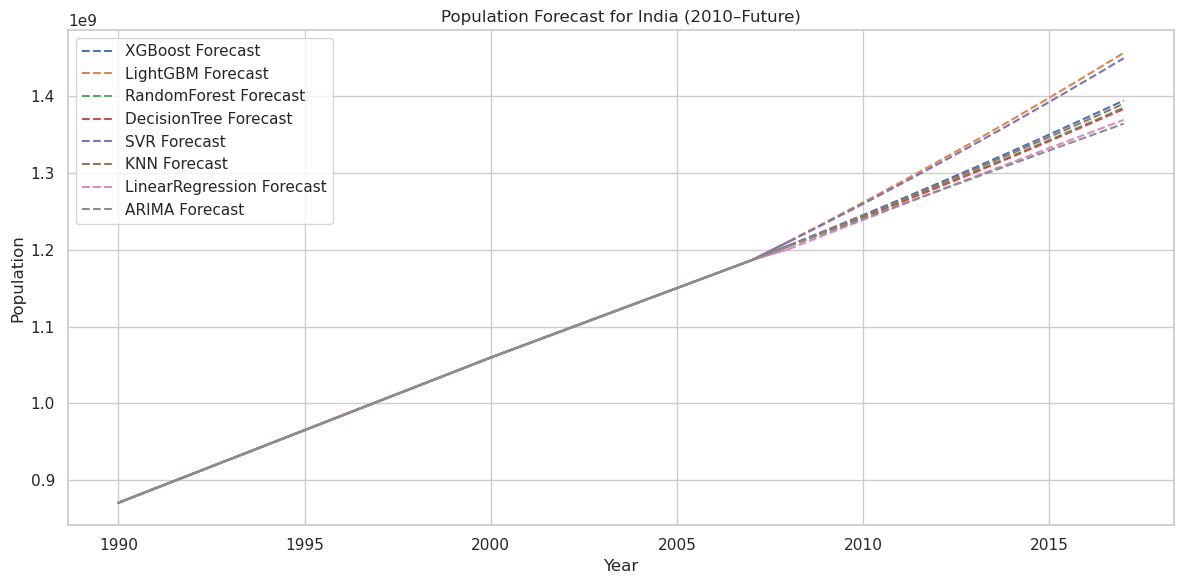

In [53]:
split_year = 2008  # prediction starts from 2023
start_year = 1990
country = 'India'

plt.figure(figsize=(12, 6))

for model_name, model_df in model_dfs.items():
    df_india = model_df[model_df['Country/Territory'] == country].sort_values('Year')
    df_india = df_india[df_india['Year'] >= start_year]

    df_hist = df_india[df_india['Year'] <= split_year]
    df_pred = df_india[df_india['Year'] >= split_year]

    if not df_hist.empty:
        line, = plt.plot(df_hist['Year'], df_hist['Population'], linestyle='-')  # no label here
    if not df_pred.empty:
        plt.plot(df_pred['Year'], df_pred['Population'], linestyle='--', color=line.get_color(), label=f"{model_name} Forecast")

plt.title(f"Population Forecast for {country} (2010–Future)")
plt.xlabel("Year")
plt.ylabel("Population")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define evaluation function
def evaluate_predictions(true, pred):
    mae = mean_absolute_error(true, pred)
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, pred)
    mape = np.mean(np.abs((true - pred) / true)) * 100
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}

# Store scores
evaluation_results = []

# Loop through each model's predictions
for model_name, model_df in model_dfs.items():
    for country in model_df['Country/Territory'].unique():
        # Filter predicted data (2008-2017)
        pred_df = model_df[(model_df['Country/Territory'] == country) & 
                           (model_df['Year'].between(2008, 2017))]
        
        # Get actual values from df_full
        actual_df = df_full[(df_full['Country/Territory'] == country) & 
                            (df_full['Year'].between(2008, 2017))]

        if not len(pred_df) or not len(actual_df):
            continue

        # Sort to align
        pred_df = pred_df.sort_values(by='Year')
        actual_df = actual_df.sort_values(by='Year')

        # Evaluate for Population, Growth, Density
        for col in ['Population', 'Growth', 'Density']:
            metrics = evaluate_predictions(actual_df[col].values, pred_df[col].values)
            metrics.update({
                'Model': model_name,
                'Country': country,
                'Feature': col
            })
            evaluation_results.append(metrics)

# Create DataFrame of results
eval_df = pd.DataFrame(evaluation_results)
eval_df.head()

# Optionally: save results to CSV
# eval_df.to_csv('model_comparison_metrics.csv', index=False)


,MAE,MSE,RMSE,R2,MAPE,Model,Country,Feature
0,156763.523452,4.107430e+10,202667.945106,0.995613,0.490335,XGBoost,Afghanistan,Population
1,0.002802,1.046960e-05,0.003236,-0.211762,8.465037,XGBoost,Afghanistan,Growth
2,0.240350,9.655363e-02,0.310731,0.995613,0.490335,XGBoost,Afghanistan,Density
3,48141.936884,4.121610e+09,64199.762795,-4.454503,1.668591,XGBoost,Albania,Population
4,0.004792,3.044027e-05,0.005517,-1.740309,283.852465,XGBoost,Albania,Growth


In [55]:
eval_df.head()

,MAE,MSE,RMSE,R2,MAPE,Model,Country,Feature
0,156763.523452,4.107430e+10,202667.945106,0.995613,0.490335,XGBoost,Afghanistan,Population
1,0.002802,1.046960e-05,0.003236,-0.211762,8.465037,XGBoost,Afghanistan,Growth
2,0.240350,9.655363e-02,0.310731,0.995613,0.490335,XGBoost,Afghanistan,Density
3,48141.936884,4.121610e+09,64199.762795,-4.454503,1.668591,XGBoost,Albania,Population
4,0.004792,3.044027e-05,0.005517,-1.740309,283.852465,XGBoost,Albania,Growth


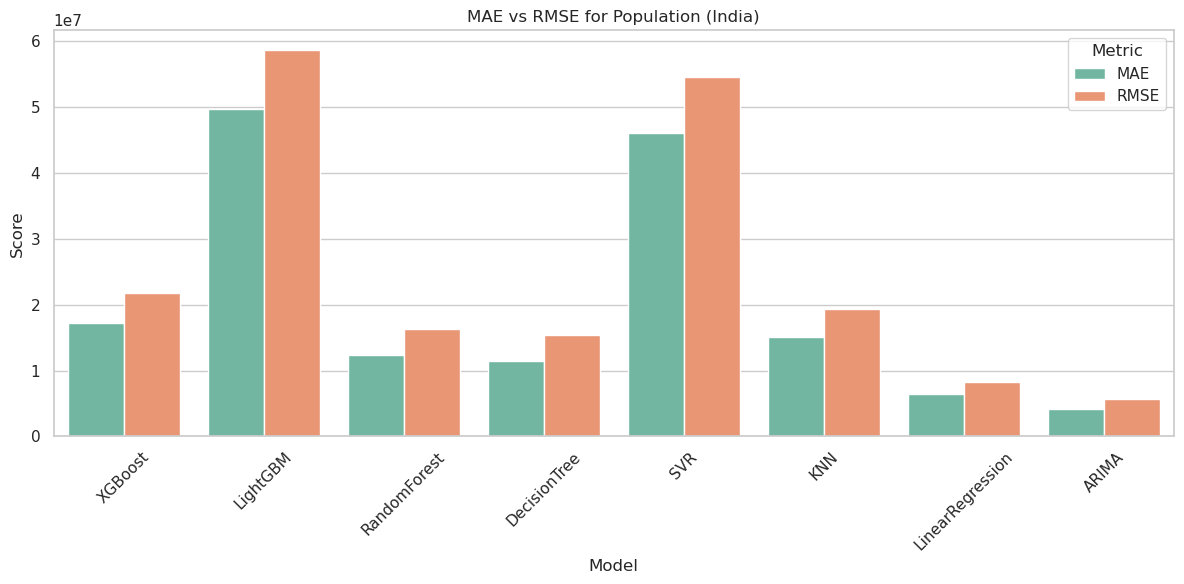

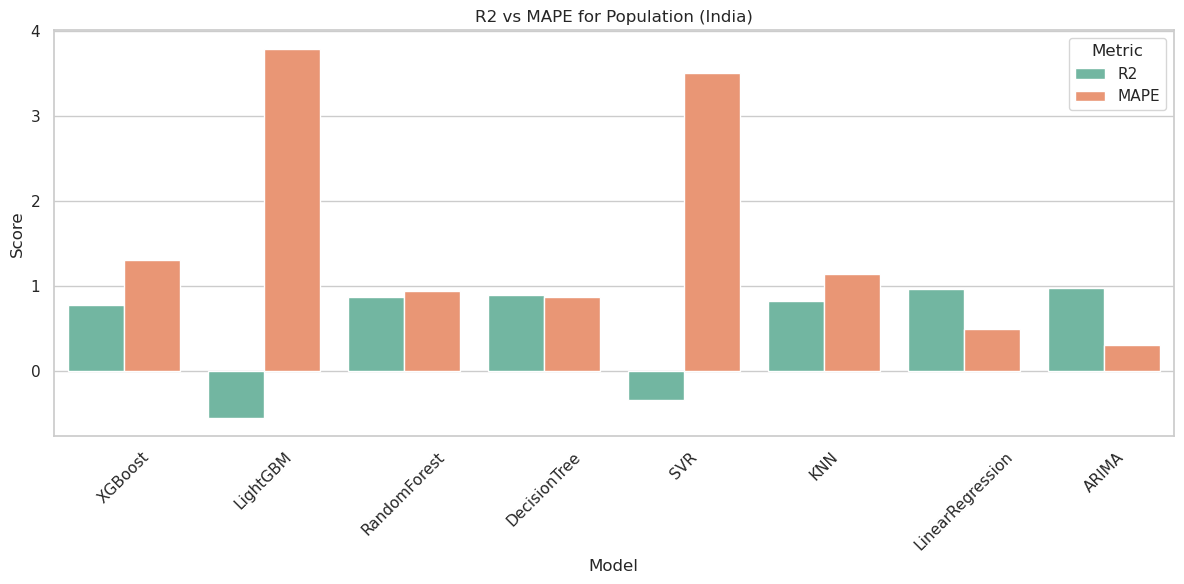

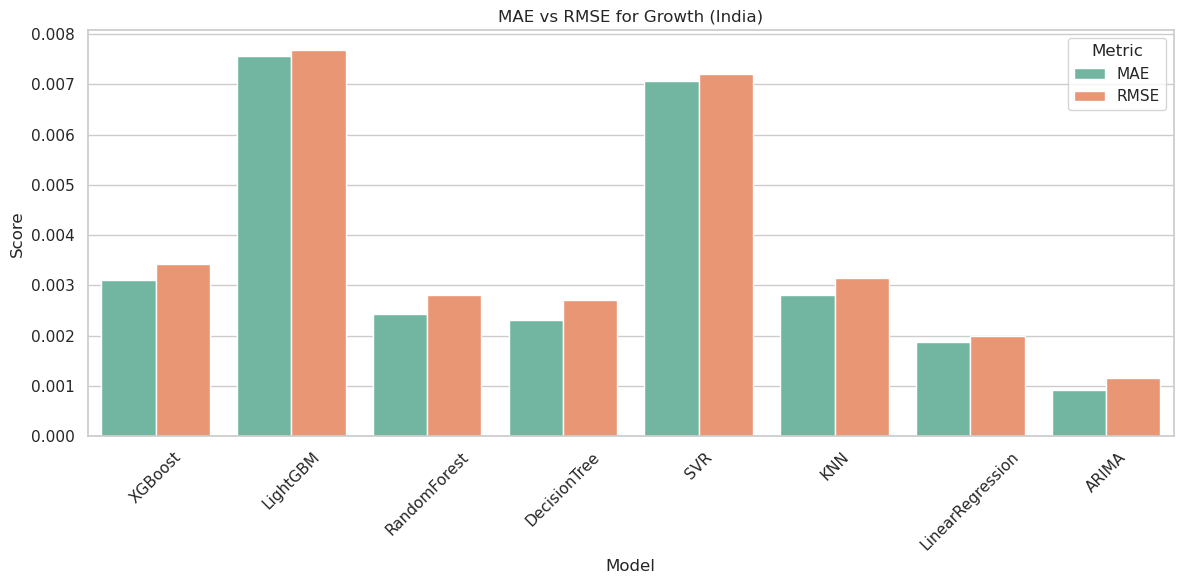

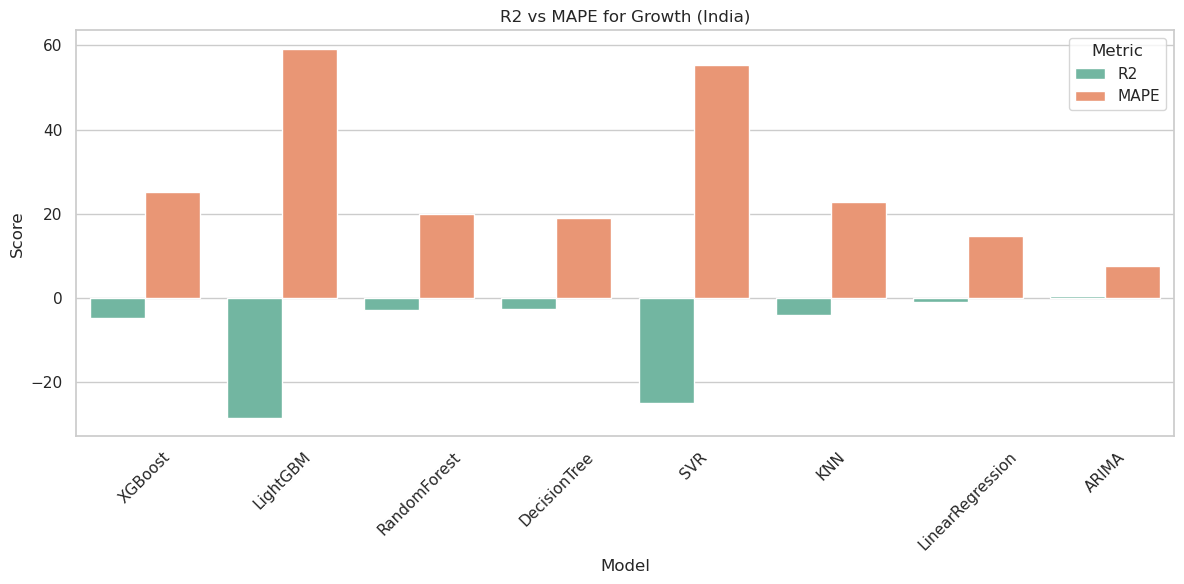

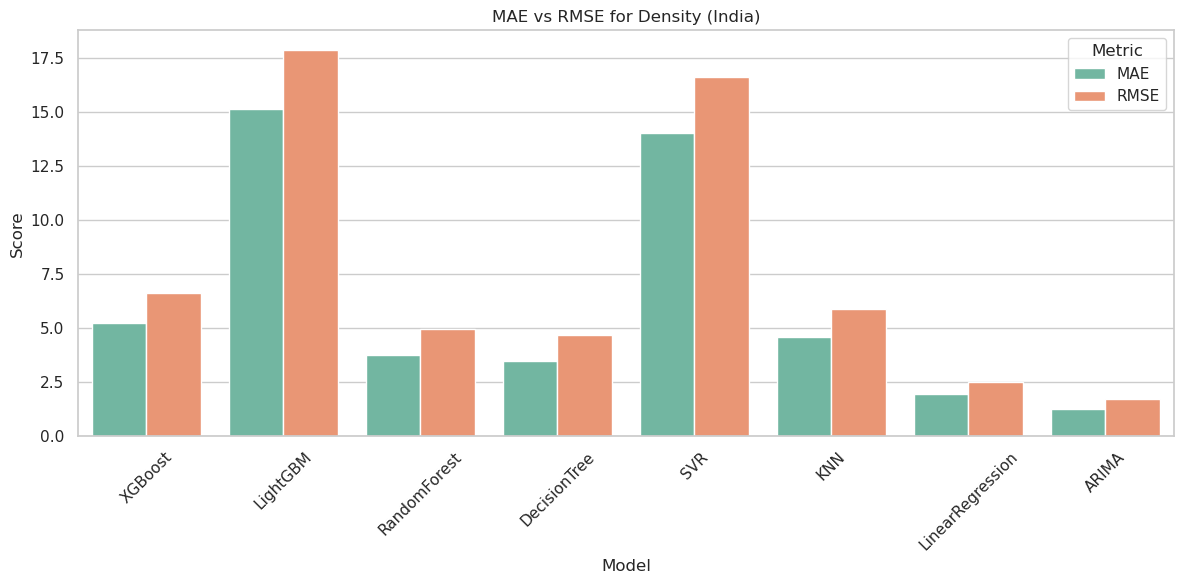

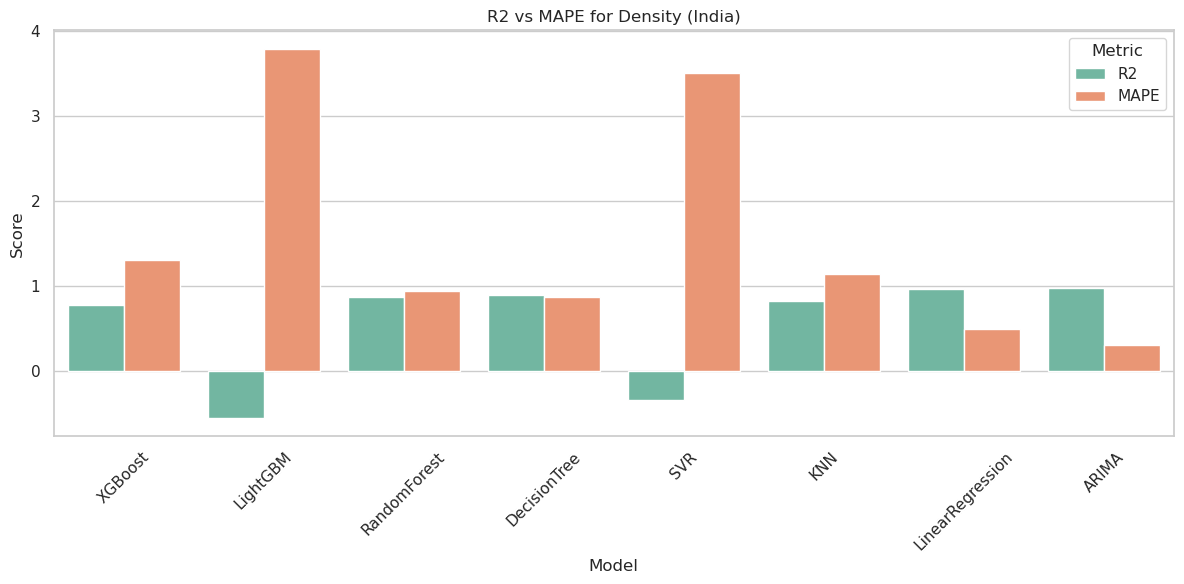

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for India
india_scores = eval_df[eval_df['Country'] == 'India']

# Plot configs
metric_groups = {
    'MAE_RMSE': ['MAE', 'RMSE'],
    'R2_MAPE': ['R2', 'MAPE']
}

# For each feature
for feature in ['Population', 'Growth', 'Density']:
    feature_df = india_scores[india_scores['Feature'] == feature]
    
    for group_name, metrics in metric_groups.items():
        melted_df = feature_df.melt(id_vars=['Model'], value_vars=metrics, 
                                    var_name='Metric', value_name='Score')

        plt.figure(figsize=(12, 6))
        sns.barplot(x='Model', y='Score', hue='Metric', data=melted_df, palette='Set2')
        plt.title(f'{group_name.replace("_", " vs ")} for {feature} (India)')
        plt.xlabel('Model')
        plt.ylabel('Score')
        plt.xticks(rotation=45)
        plt.legend(title='Metric')
        plt.tight_layout()
        plt.show()
